In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
import pickle
import tensorflow as tf
import tensorflow_io as tfio
import os
import sys
from numpy import argmax

sys.path.insert(0, '../VisualizationTools')
import get_data_from_XML, get_gt, getUID, roi2rect, utils, visualization

from sklearn.metrics import f1_score, mean_squared_error, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB3
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, Input
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [2]:
#Convert a numpy 3d array of a bitmap of an rgb image to grayscale
#using the formula (0.3 * R) + (0.59 * G) + (0.11 * B) 
def rgb_bmp_togray(imgbmp):
    r = imgbmp[:,:,0]
    g = imgbmp[:,:,1]
    b = imgbmp[:,:,2]
    graybmp = np.multiply(0.3*r, 0.59*g)
    graybmp = np.multiply(graybmp, .11*b)
    
    return graybmp

#Intersection over union calculation given two bounding boxes
def IOU(bbox1, bbox2):
    xmin1, ymin1, xmax1, ymax1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    xmin2, ymin2, xmax2, ymax2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    x_intersection = 0
    if xmin1 <= xmax2 and xmin2 <= xmax1:
        x_intersection = min(xmax1, xmax2) - max(xmin1, xmin2)
        
    y_intersection = 0
    if ymin1 <= ymax2 and ymin2 <= ymax1:
        y_intersection = min(ymax1, ymax2) - max(ymin1, ymin2)
    
    intersection = x_intersection * y_intersection
    
    if intersection == 0:
        return 0
    
    union = (xmax1-xmin1)*(ymax1-ymin1) + (xmax2-xmin2)*(ymax2-ymin2) - intersection
    
    return intersection/union
    

    return I / U

dicom_path = '../images/smallTraining/'
annotation_path = '../annot/Annotation/'

anfilenames = os.listdir(annotation_path)
lungfilenames = os.listdir(dicom_path)
num_classes = 4
xtotal = []
ybox = []
yclass = []
for aname in anfilenames:
    #if np.random.random() > .1:
    #    continue
    anpath = annotation_path + aname
    lungpath = dicom_path + "Lung_Dx-" + aname
    if not os.path.isdir(lungpath):
        print("missing: ", lungpath)
        continue
    lungs = getUID.getUID_path(lungpath)
    annotations = get_data_from_XML.XML_preprocessor(anpath, num_classes=num_classes).data
    for k, v in annotations.items():
        
        key = k[:-4]
        if key not in lungs:
            print("missing key: ", k)
            continue
        dcm_path, dcm_name = lungs[k[:-4]]
        matrix, frame_num, width, height, ch = utils.loadFile(dcm_path)
        img_bitmap = utils.MatrixToImage(matrix[0], ch)
        xbmp = img_bitmap
        if len(img_bitmap.shape) > 2: #assume bitmap is rgb
            xbmp = rgb_bmp_togray(img_bitmap)
        xbmp = xbmp.reshape(np.prod(xbmp.shape))/255
        xtotal.append(xbmp)

        #extract xmin, ymin, xmax, ymax in that order
        ybox.append(np.array([v[0][0], v[0][1], v[0][2], v[0][3]]))
        yclass.append(np.array([v[0][4], v[0][5], v[0][6], v[0][7]]))
    

        
        
        
xtotal = np.array(xtotal)
ybox = np.array(ybox)
yclass = np.array(yclass)

missing:  ../images/smallTraining/Lung_Dx-A0001
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.131943461111501120339653486778.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.178836002044492899997583802620.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.298515116091921420006643787707.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.353855695020176158431198172735.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.386936544335940634104504855125.xml
missing:  ../images/smallTraining/Lung_Dx-A0005
missing:  ../images/smallTraining/Lung_Dx-A0006
missing:  ../images/smallTraining/Lung_Dx-A0007
missing:  ../images/smallTraining/Lung_Dx-A0008
missing:  ../images/smallTraining/Lung_Dx-A0009
missing:  ../images/smallTraining/Lung_Dx-A0010
missing:  ../images/smallTraining/Lung_Dx-A0011
missing:  ../images/smallTraining/Lung_Dx-A0012
missing:  ../images/smallTraining/Lung_Dx-A0013
missing:  ../images/smallTraining/Lung_Dx-A0014
missing:  ../images/smallTraining/Lung_Dx-A0015
missing: 

In [3]:
print(xtotal.shape)
print(ybox.shape)
print(yclass.shape)

(925, 262144)
(925, 4)
(925, 4)


In [4]:
X_train, X_test, y_train_box, y_test_box, y_train_class, y_test_class = train_test_split(xtotal, ybox, yclass, random_state = 2022)

In [5]:
duales = EarlyStopping(patience = 50, monitor = 'loss')

In [6]:
visible = Input(shape=(X_train.shape[-1],))
hidden1 = Dense(20, activation='relu')(visible)
hidden2 = Dense(10, activation='relu')(hidden1)

out_reg = Dense(y_train_box.shape[-1], activation='relu')(hidden2)
out_class = Dense(4, activation='softmax')(hidden2)

In [7]:
simple_model = Model(inputs=visible, outputs=[out_reg, out_class])
simple_model.compile(loss=['mse','categorical_crossentropy'], optimizer='adam')
simple_model.fit(X_train, [y_train_box, y_train_class], epochs = 1000, batch_size = 32, verbose = 2, callbacks = duales)

Epoch 1/1000
22/22 - 2s - loss: 192778.6875 - dense_2_loss: 191084.2188 - dense_3_loss: 1694.4805 - 2s/epoch - 93ms/step
Epoch 2/1000
22/22 - 0s - loss: 67746.5938 - dense_2_loss: 65304.2578 - dense_3_loss: 2442.3235 - 307ms/epoch - 14ms/step
Epoch 3/1000
22/22 - 0s - loss: 59653.6172 - dense_2_loss: 57217.2969 - dense_3_loss: 2436.3083 - 307ms/epoch - 14ms/step
Epoch 4/1000
22/22 - 0s - loss: 56702.7305 - dense_2_loss: 54424.2148 - dense_3_loss: 2278.5061 - 302ms/epoch - 14ms/step
Epoch 5/1000
22/22 - 0s - loss: 55141.1836 - dense_2_loss: 53039.2383 - dense_3_loss: 2101.9417 - 314ms/epoch - 14ms/step
Epoch 6/1000
22/22 - 0s - loss: 53820.3477 - dense_2_loss: 51931.2031 - dense_3_loss: 1889.1421 - 308ms/epoch - 14ms/step
Epoch 7/1000
22/22 - 0s - loss: 53123.3828 - dense_2_loss: 51441.4883 - dense_3_loss: 1681.8973 - 304ms/epoch - 14ms/step
Epoch 8/1000
22/22 - 0s - loss: 52469.2812 - dense_2_loss: 51010.7070 - dense_3_loss: 1458.5759 - 308ms/epoch - 14ms/step
Epoch 9/1000
22/22 - 0s -

In [8]:
#invert any bounding box that is backwards
ypred, ypredclass = simple_model.predict(X_test)
for box in ypred:
    if box[0] > box[2]:
        temp = box[0]
        box[0] = box[2]
        box[2] = temp
    if box[1] > box[3]:
        temp = box[1]
        box[1] = box[3]
        box[3] = box[1]

8/8 [==============================] - 0s 8ms/step


In [17]:
error = mean_squared_error(y_test_box, ypred)
print('MAE: %.3f' % error)

acc = f1_score(argmax(y_test_class, axis=-1).astype('int'), argmax(ypredclass, axis=-1).astype('int'), average = 'macro')
print('f1_score: %.3f' % acc)

multilabel_confusion_matrix(argmax(y_test_class, axis=-1).astype('int'), argmax(ypredclass, axis=-1).astype('int'))

MAE: 29732.437
f1_score: 0.479


array([[[132,  30],
        [ 17,  53]],

       [[120,  41],
        [ 14,  57]],

       [[189,  23],
        [ 16,   4]],

       [[155,   6],
        [ 53,  18]]], dtype=int64)

In [21]:
ious = [IOU(ypred[i], y_test_box[i]) for i in range(len(y_test_box))]
imin = ious.index(min(ious))
print("Max IOU:", max(ious))
print("Min IOU:",min(ious))
print("Total testing length:", len(ious))
print(IOU(ypred[imin], y_test_box[imin]))
print("Average IOU: {}".format(sum(ious)/len(ious)))
hitious = [iou for iou in ious if iou != 0]
print("Total nonzero IOUs:", len(hitious))
print("Average IOU without misses: {}".format(sum(hitious)/len(hitious)))

Max IOU: 0.46875539275264283
Min IOU: 0
Total testing length: 232
0
Average IOU: 0.15624137456324858
Total nonzero IOUs: 183
Average IOU without misses: 0.19807649671406377


[array([180.262146  ,   0.        , 260.68637085, 319.01812744,
         1.        ,   0.        ,   0.        ,   0.        ])]


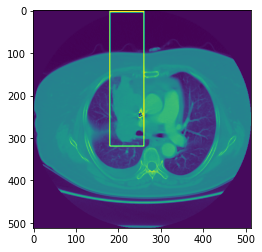

In [51]:
#display image of best prediction
imax = ious.index(max(ious))
data = [np.hstack((np.asarray(ypred[imax]), np.asarray([1,0,0,0])))]
img_bitmap = X_test[imax]*255
img_bitmap = img_bitmap.reshape((512,512))
print(data)
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)
plt.savefig('../myVisuals/bestPred.png')

[array([181., 150., 275., 326.,   1.,   0.,   0.,   0.])]


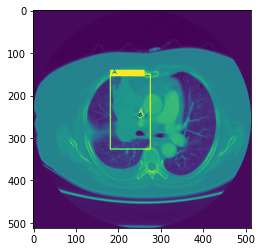

In [52]:
#display image of best prediction
imax = ious.index(max(ious))
data = [np.hstack((np.asarray(y_test_box[imax]), np.asarray([1,0,0,0])))]
img_bitmap = X_test[imax]*255
img_bitmap = img_bitmap.reshape((512,512))
print(data)
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)
plt.savefig('../myVisuals/actualBestPred.png')

[207. 288. 238. 325.] [0. 0. 0. 0.]


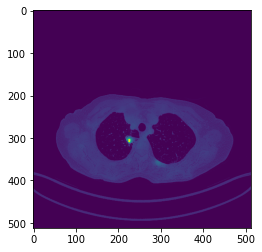

In [49]:
imin = ious.index(min(ious))
print(y_test_box[imin], ypred[imin])
data = [np.hstack((np.asarray(ypred[imin]), np.asarray([1,0,0,0])))]
img_bitmap = X_test[imin]*255
img_bitmap = img_bitmap.reshape((512,512))
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)
plt.savefig('../myVisuals/worstPred.png')

[207. 288. 238. 325.] [0. 0. 0. 0.]


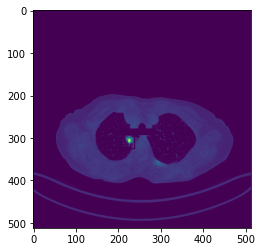

In [50]:
print(y_test_box[imin], ypred[imin])
data = [np.hstack((np.asarray(y_test_box[imin]), np.asarray([1,0,0,0])))]
img_bitmap = X_test[imin]*255
img_bitmap = img_bitmap.reshape((512,512))
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)
plt.savefig('../myVisuals/actualWorstPred.png')

[162. 259. 206. 307.] [152.68375   0.      212.6567  312.46906]


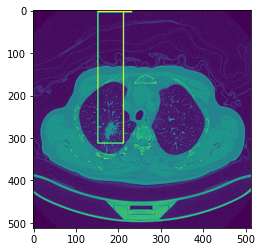

In [47]:
#display image of worst prediction that didn't miss completely
imin = hitious.index(min(hitious))
print(y_test_box[imin], ypred[imin])
data = [np.hstack((np.asarray(ypred[imin]), np.asarray([1,0,0,0])))]
img_bitmap = X_test[imin]*255
img_bitmap = img_bitmap.reshape((512,512))
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])

plt.imshow(test)
plt.savefig('../myVisuals/mediumPred.png')

[162. 259. 206. 307.] [152.68375   0.      212.6567  312.46906]


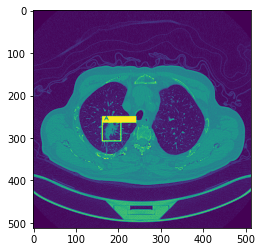

In [39]:
#display image of worst prediction that didn't miss completely
imin = hitious.index(min(hitious))
print(y_test_box[imin], ypred[imin])
data = [np.hstack((np.asarray(y_test_box[imin]), np.asarray([1,0,0,0])))]
img_bitmap = X_test[imin]*255
img_bitmap = img_bitmap.reshape((512,512))
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])

plt.imshow(test)
plt.savefig('../myVisuals/actualMediumPred.png')